In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split
from nltk import FreqDist
from wordcloud import WordCloud
from pathlib import Path

Se consulta los datos en la pagina oficial de Conagua, se pasan los datos manualmente desde el año 2020 al 2025 a un archivo Excel para cada año https://smn.conagua.gob.mx/es/climatologia/temperaturas-y-lluvias/resumenes-mensuales-de-temperaturas-y-lluvias.

Se sube la carpeta con los csv de los datos a un dataframes(diccionario) para poder llamarlos durante su analisis

In [2]:
carpeta = Path(r"C:\Users\sayur\Downloads\Proyecto_Bedu\data\utf8")
dataframes = {}  # diccionario vacío

for archivo in carpeta.glob('*.csv'):
    nombre_tabla = archivo.stem
    dataframes[nombre_tabla] = pd.read_csv(archivo, dtype=str, low_memory=False, na_filter=True)

In [3]:
# Se confirma si se subieron los csv
for k in dataframes.keys():
    print(k)

2020
2021
2022
2023
2024
2025


Se define el nombre que tendra para poder usarlos en el analisis

In [4]:
df_2025=dataframes["2025"]
df_2024=dataframes["2024"]
df_2023=dataframes["2023"]
df_2022=dataframes["2022"]
df_2021=dataframes["2021"]
df_2020=dataframes["2020"]

Se hace la normalizacion de los datos, convirtiendolos a minusculas, manejo de nulos y los campos que son numericos. Se hace este este proceso porque la data no es tan grande y se reviso con anterioridad, no son necesarias otras transformaciones para utilizar la data.

In [5]:
for nombre, df in dataframes.items():
    # columnas a minúsculas
    df.columns = df.columns.str.lower()

    # contenido a minúsculas en columnas de texto
    for col in df.select_dtypes(include="object").columns:
        df[col] = df[col].map(lambda x: x.lower() if isinstance(x, str) else x)

        # reemplazar valores de texto que representan nulos por NaN real
        df[col] = df[col].replace(
            ["nan", "null", "none", "na", "", " "], 
            np.nan
        )

    dataframes[nombre] = df

In [6]:
for nombre, df in dataframes.items():
    # convertir columnas numéricas de texto a float
    for col in df.select_dtypes(include="object").columns:
        try:
            df[col] = df[col].astype(float)
        except:
            pass  # ignora si no se puede convertir

    dataframes[nombre] = df

### Visualizacion de datos

In [7]:
# Primeras filas
df_2025.head(2)

,estado,ene,feb,mar,abr,may,jun,jul,ago,sep,oct,nov,dic,anual
0,aguascalientes,9.5,0.0,0.0,0.1,32.7,157.8,143.8,139.3,483.2,NaN,NaN,NaN,NaN
1,bajacalifornia,3.8,4.7,28.9,3.2,2.4,5.4,0.3,7.8,56.4,NaN,NaN,NaN,NaN


## Estadísticas descriptivas

In [8]:
df_2025.describe()

,ene,feb,mar,abr,may,jun,jul,ago,sep,oct,nov,dic,anual
count,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,0.0,0.0,0.0,0.0
mean,23.790909,18.118182,8.078788,7.387879,63.181818,198.727273,127.681818,153.093939,600.033333,NaN,NaN,NaN,NaN
std,25.669332,27.465290,12.285351,11.827768,54.445675,120.814184,61.176208,94.726775,307.556968,NaN,NaN,NaN,NaN
min,1.200000,0.000000,0.000000,0.000000,0.600000,3.500000,0.300000,7.800000,56.400000,NaN,NaN,NaN,NaN
25%,9.500000,0.100000,0.100000,0.300000,28.600000,89.800000,99.200000,91.800000,446.000000,NaN,NaN,NaN,NaN
50%,14.000000,5.600000,2.700000,2.600000,59.200000,189.700000,125.300000,139.300000,570.300000,NaN,NaN,NaN,NaN
75%,30.200000,19.300000,8.400000,8.600000,80.400000,262.300000,163.100000,189.700000,799.900000,NaN,NaN,NaN,NaN
max,113.400000,122.400000,55.500000,55.400000,260.700000,466.000000,264.600000,400.400000,1415.400000,NaN,NaN,NaN,NaN


## Análisis descriptivo por año y estado

In [9]:
# --- 1. Promedio anual por estado ---
promedio_anual = df[["estado","anual"]].sort_values("anual", ascending=False)
print("Promedio anual por estado (2025):\n", promedio_anual)

# --- 2. Promedio mensual nacional ---
promedio_mensual = df.drop(columns=["estado","anual"]).mean()
print("\nPromedio mensual nacional (2025):\n", promedio_mensual)

# --- 3. Desviación estándar (variabilidad entre estados) ---
variabilidad = df.drop(columns=["estado"]).std()
print("\nDesviación estándar (2025):\n", variabilidad)

# --- 4. Tendencia anual ---
anuales = {}
for year, dfx in dataframes.items():
    anuales[year] = dfx["anual"].astype(float).mean()

df_tendencia = pd.DataFrame.from_dict(anuales, orient="index", columns=["promedio_anual"])
print("\nPromedio anual nacional por año:\n", df_tendencia)


Promedio anual por estado (2025):
                estado  anual
0      aguascalientes    NaN
1      bajacalifornia    NaN
2   bajacaliforniasur    NaN
3            campeche    NaN
4            coahuila    NaN
5              colima    NaN
6             chiapas    NaN
7           chihuahua    NaN
8      ciudaddeméxico    NaN
9             durango    NaN
10         guanajuato    NaN
11           guerrero    NaN
12            hidalgo    NaN
13            jalisco    NaN
14     estadodeméxico    NaN
15          michoacán    NaN
16            morelos    NaN
17            nayarit    NaN
18          nuevoleón    NaN
19             oaxaca    NaN
20             puebla    NaN
21          querétaro    NaN
22        quintanaroo    NaN
23      sanluispotosí    NaN
24            sinaloa    NaN
25             sonora    NaN
26            tabasco    NaN
27         tamaulipas    NaN
28           tlaxcala    NaN
29           veracruz    NaN
30            yucatán    NaN
31          zacatecas    NaN
32      

## Lluvia en 2025

Se puede observar que las graficas a partir del mes de octubre no cuenta con datos, por lo que solo se hara una visualizacon sencilla de la informacion. 

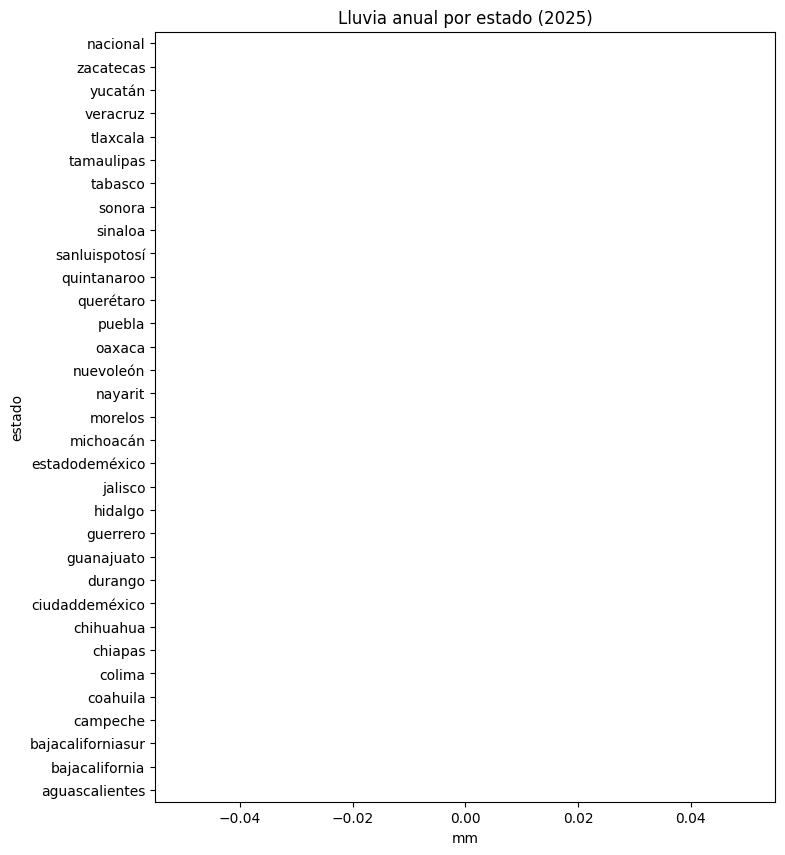

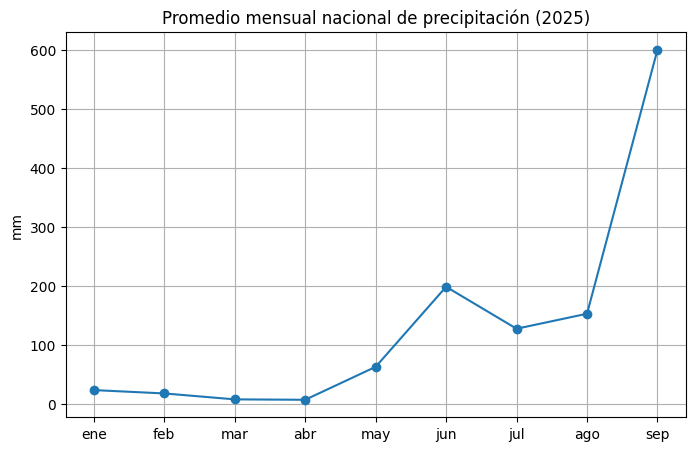

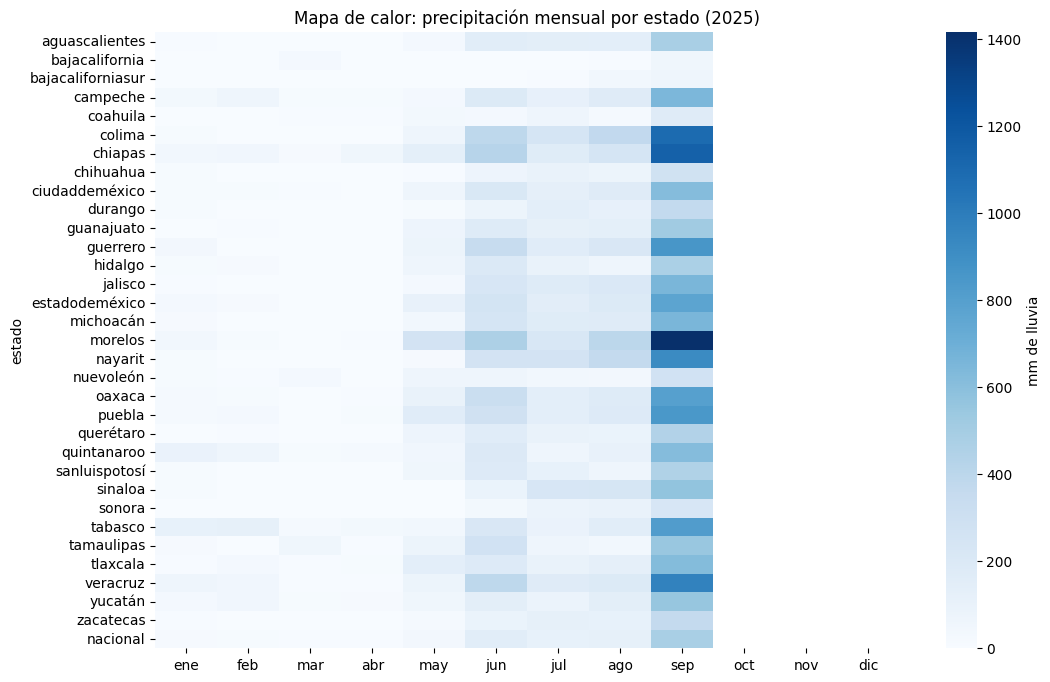

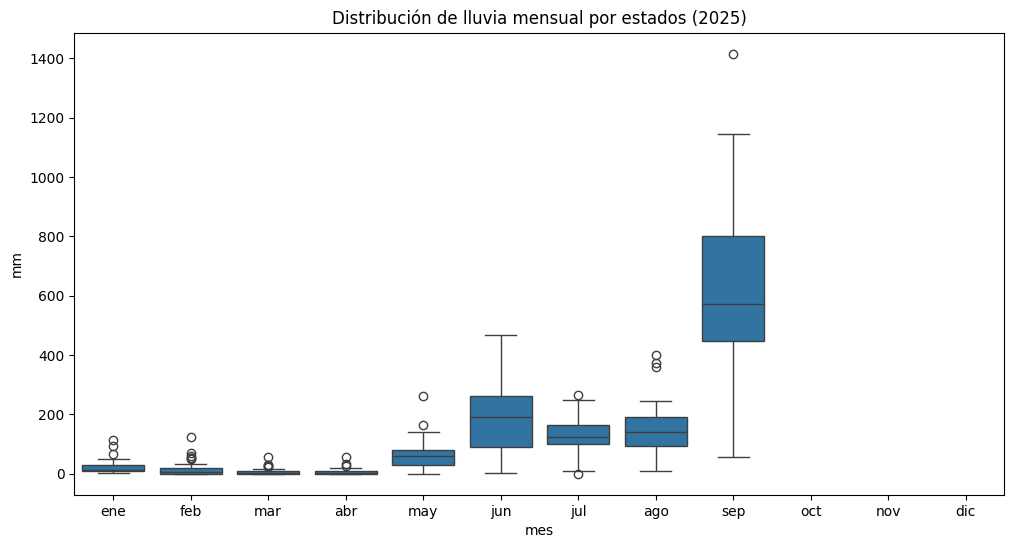

In [10]:
# --- 1. Barra horizontal: lluvia anual por estado ---
df.set_index("estado")["anual"].astype(float).sort_values().plot(kind="barh", figsize=(8,10))
plt.title("Lluvia anual por estado (2025)")
plt.xlabel("mm")
plt.show()

# --- 2. Promedio mensual nacional ---
promedio_mensual.plot(kind="line", marker="o", figsize=(8,5))
plt.title("Promedio mensual nacional de precipitación (2025)")
plt.ylabel("mm")
plt.grid(True)
plt.show()

# --- 3. Mapa de calor por estado y mes ---
plt.figure(figsize=(12,8))
df_meses = df.set_index("estado").drop(columns="anual").astype(float)
sns.heatmap(df_meses, cmap="Blues", cbar_kws={'label': 'mm de lluvia'})
plt.title("Mapa de calor: precipitación mensual por estado (2025)")
plt.show()

# --- 4. Boxplot por mes ---
df_melt = df.melt(id_vars="estado", value_vars=["ene","feb","mar","abr","may","jun","jul","ago","sep","oct","nov","dic"],
                  var_name="mes", value_name="lluvia")
df_melt["lluvia"] = df_melt["lluvia"].astype(float)

plt.figure(figsize=(12,6))
sns.boxplot(data=df_melt, x="mes", y="lluvia")
plt.title("Distribución de lluvia mensual por estados (2025)")
plt.ylabel("mm")
plt.show()

Se realiza esta funcion  para analizar solo los csv del 2020-2024 del dataframes.

In [11]:
anios = ["2020","2021","2022","2023","2024"]

meses = {
    "ene":1, "feb":2, "mar":3, "abr":4, "may":5, "jun":6,
    "jul":7, "ago":8, "sep":9, "oct":10, "nov":11, "dic":12
}

dfs_long = []

for anio in anios:
    df = dataframes[anio]  
    df.columns = df.columns.str.lower()
    
    df_long = df.melt(id_vars="estado",
                      value_vars=meses.keys(),
                      var_name="mes", value_name="lluvia_mm")
    
    df_long["mes"] = df_long["mes"].map(meses)
    df_long["anio"] = int(anio)
    
    dfs_long.append(df_long)

# Concatenar todos los años
df_all = pd.concat(dfs_long, ignore_index=True)

# Convertir lluvia a numérico
df_all["lluvia_mm"] = pd.to_numeric(df_all["lluvia_mm"], errors="coerce")

print(df_all.head())

              estado  mes  lluvia_mm  anio
0     aguascalientes    1       38.5  2020
1     bajacalifornia    1        4.3  2020
2  bajacaliforniasur    1        1.9  2020
3           campeche    1       31.1  2020
4           coahuila    1       11.3  2020


## Promedio mensual nacional por año

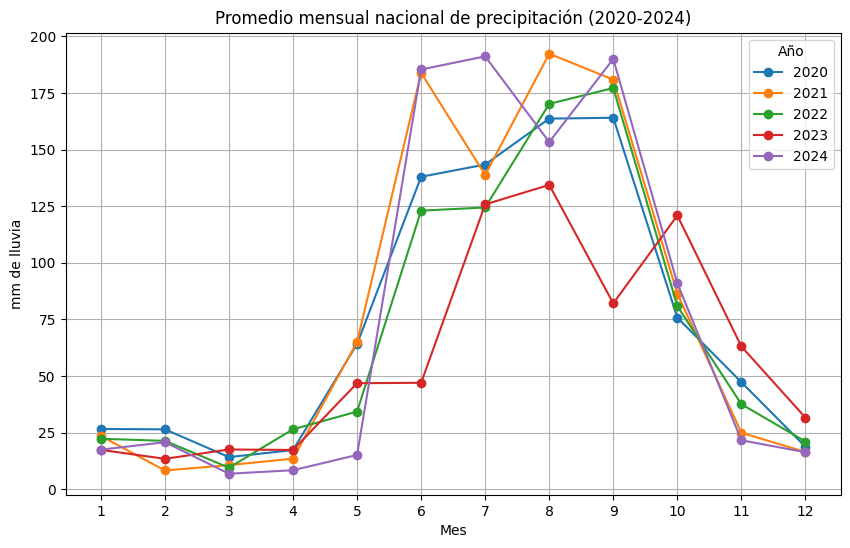

In [12]:
promedio_mensual_nacional = df_all.groupby(["anio","mes"])["lluvia_mm"].mean().unstack(level=0)

plt.figure(figsize=(10,6))
for anio in anios:
    plt.plot(promedio_mensual_nacional.index, promedio_mensual_nacional[int(anio)], marker="o", label=anio)

plt.title("Promedio mensual nacional de precipitación (2020-2024)")
plt.xlabel("Mes")
plt.ylabel("mm de lluvia")
plt.xticks(range(1,13))
plt.grid(True)
plt.legend(title="Año")
plt.show()


## Promedio anual por estado

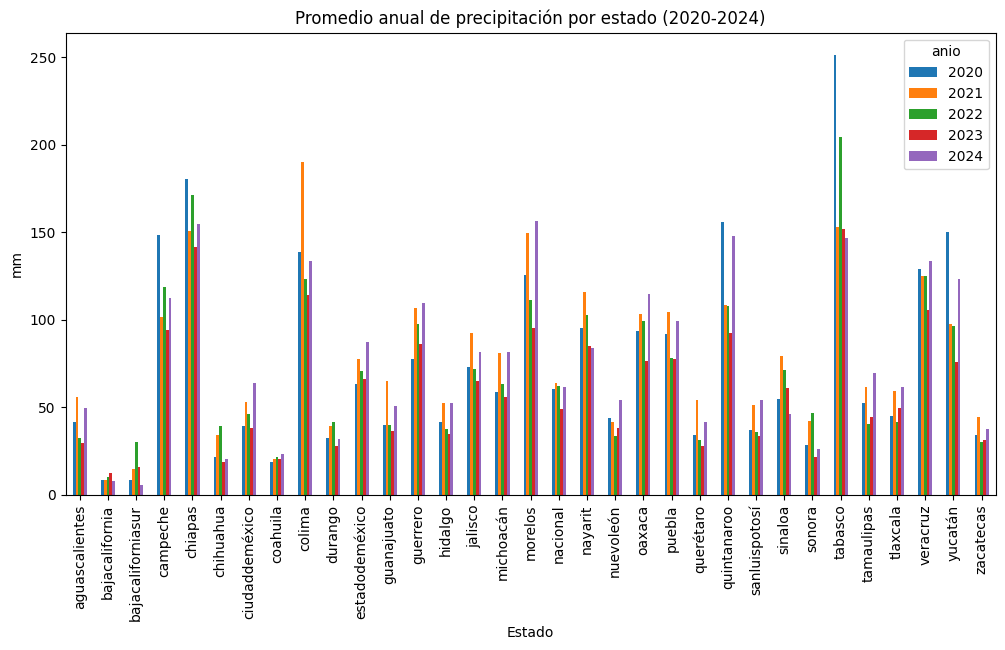

In [13]:
promedio_estado = df_all.groupby(["estado","anio"])["lluvia_mm"].mean().unstack()
promedio_estado.plot(kind="bar", figsize=(12,6))
plt.title("Promedio anual de precipitación por estado (2020-2024)")
plt.ylabel("mm")
plt.xlabel("Estado")
plt.xticks(rotation=90)
plt.show()


## Heatmap mensual por estado (2020-2024)

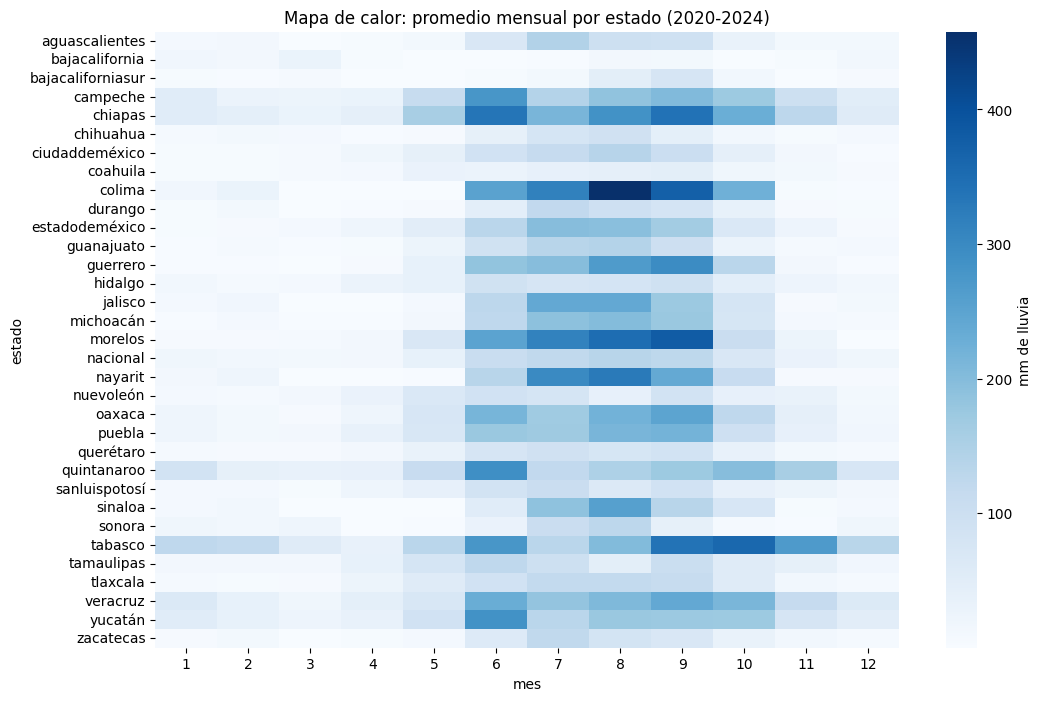

In [14]:
df_heatmap = df_all.groupby(["estado","mes"])["lluvia_mm"].mean().unstack()
plt.figure(figsize=(12,8))
sns.heatmap(df_heatmap, cmap="Blues", cbar_kws={'label':'mm de lluvia'})
plt.title("Mapa de calor: promedio mensual por estado (2020-2024)")
plt.show()


## Scatter plot con tamaño por lluvia

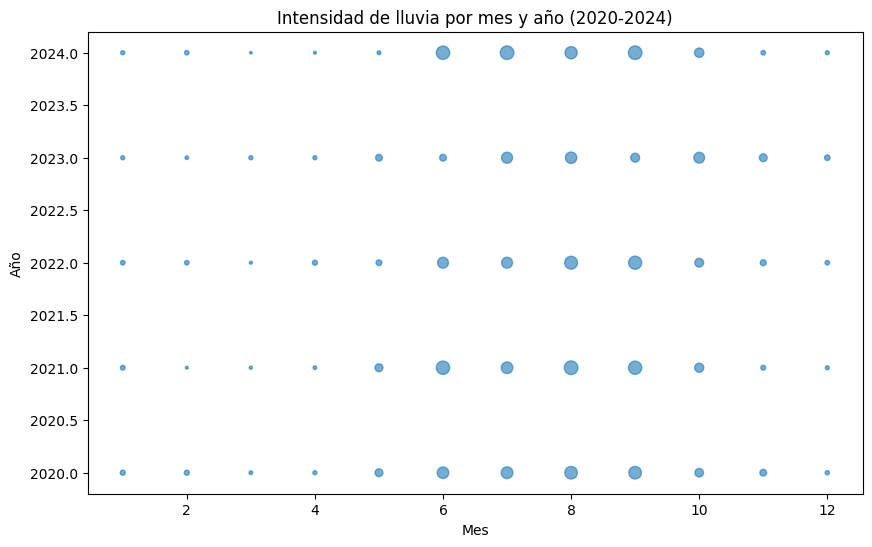

In [15]:
df_scatter = df_all.groupby(["anio","mes"])["lluvia_mm"].mean().reset_index()

plt.figure(figsize=(10,6))
plt.scatter(df_scatter["mes"], df_scatter["anio"], s=df_scatter["lluvia_mm"]*0.5, alpha=0.6)
plt.title("Intensidad de lluvia por mes y año (2020-2024)")
plt.xlabel("Mes")
plt.ylabel("Año")
plt.show()

## Heatmap anual vs mes

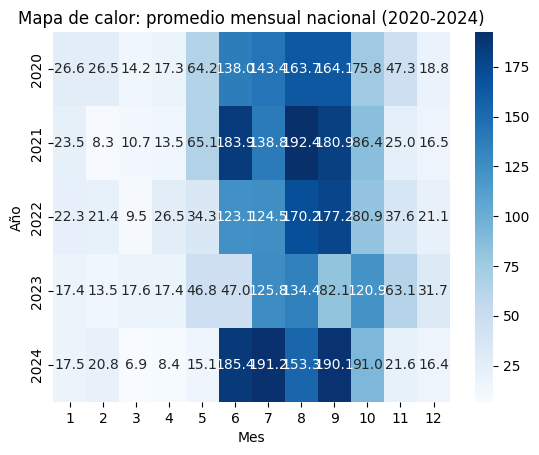

In [16]:
df_heatmap2 = df_all.groupby(["anio","mes"])["lluvia_mm"].mean().unstack()
sns.heatmap(df_heatmap2, cmap="Blues", annot=True, fmt=".1f")
plt.title("Mapa de calor: promedio mensual nacional (2020-2024)")
plt.xlabel("Mes")
plt.ylabel("Año")
plt.show()

## Treemap (mapa de áreas)

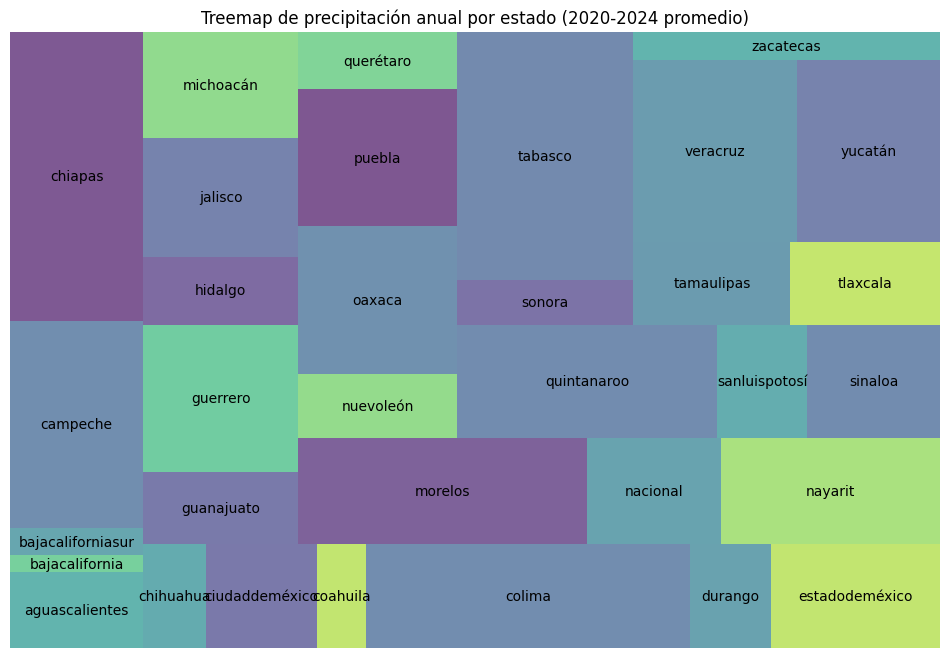

In [17]:
import squarify

promedio_anual_estado = df_all.groupby("estado")["lluvia_mm"].sum()
plt.figure(figsize=(12,8))
squarify.plot(sizes=promedio_anual_estado.values, label=promedio_anual_estado.index, alpha=0.7)
plt.title("Treemap de precipitación anual por estado (2020-2024 promedio)")
plt.axis("off")
plt.show()

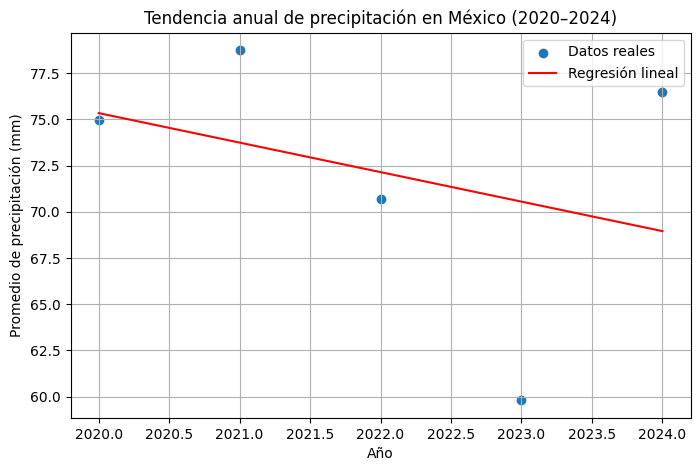

Pendiente: -1.60 mm/año
Intercepto: 3299.69


In [18]:
# Promedio anual por año
prom_anual = df_all.groupby("anio")["lluvia_mm"].mean().reset_index()

# Variables
X = prom_anual[["anio"]]
y = prom_anual["lluvia_mm"]

# Modelo
modelo = LinearRegression()
modelo.fit(X, y)

# Predicciones
y_pred = modelo.predict(X)

# Gráfica
plt.figure(figsize=(8,5))
plt.scatter(X, y, label="Datos reales")
plt.plot(X, y_pred, color="red", label="Regresión lineal")
plt.xlabel("Año")
plt.ylabel("Promedio de precipitación (mm)")
plt.title("Tendencia anual de precipitación en México (2020–2024)")
plt.legend()
plt.grid(True)
plt.show()

# Coeficiente y pendiente
print(f"Pendiente: {modelo.coef_[0]:.2f} mm/año")
print(f"Intercepto: {modelo.intercept_:.2f}")